<a href="https://colab.research.google.com/github/anuva05/PracticalDeepLearningCourse/blob/master/Lesson7_ResNet_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST CNN

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/testing'),
 PosixPath('/root/.fastai/data/mnist_png/training')]

In [0]:
#To see where convert_mode value comes from- see details in python imaging library
il = ImageList.from_folder(path, convert_mode='L')

In [6]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/testing/5/8863.png')

In [0]:
defaults.cmap='binary'

In [8]:
#We have 70000 images of size 28x28
#Note: Pytorch puts channel dimension first (RGB)
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

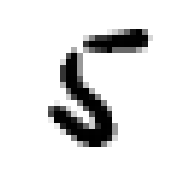

In [9]:
il[0].show()

In [0]:
sd = il.split_by_folder(train='training', valid='testing')
#If splitting not required, we must explicity say so using 'no_split'

In [11]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [12]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/2')]

In [0]:
ll = sd.label_from_folder()

In [14]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
5,5,5,5,5
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
5,5,5,5,5
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
# Index into the label list 'll'
# y are category objects (the label)
#x is image object 
x,y = ll.train[0]

5 torch.Size([1, 28, 28])


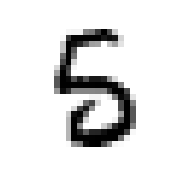

In [16]:
x.show()
print(y,x.shape)

In [0]:
#Not using get_transforms function cause cannot rotate/flip an image of a digit
#Just do padding.
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [0]:
ll = ll.transform(tfms)

In [0]:
bs = 128

In [0]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [0]:
x,y = data.train_ds[0]

5


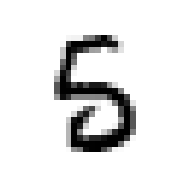

In [22]:
x.show()
print(y)

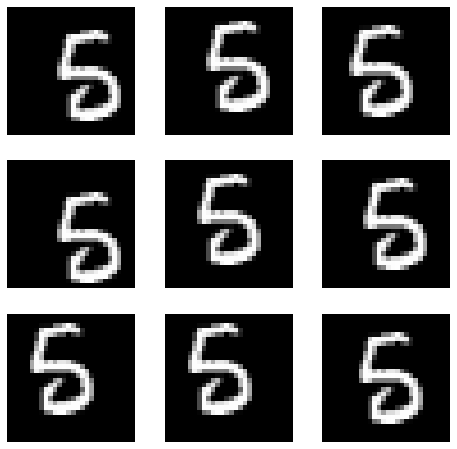

In [23]:
#plot_multi is fastai function
#random padding leads to the following transforms (digit moved around)
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [24]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

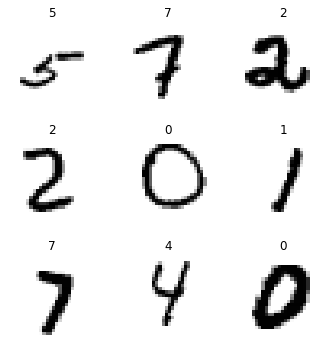

In [25]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [0]:
#Using these hyperparameters, size of output = (W - F + 2P)/S + 1
#W=inputsize = 28, F= filter size = 3, P= 1, S =2 ==> output=  14 x 14
#ni = num. channels coming in, nf =num. channels in output
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [0]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [29]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [0]:
xb = xb.cuda()

In [31]:
model(xb).shape

torch.Size([128, 10])

In [32]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


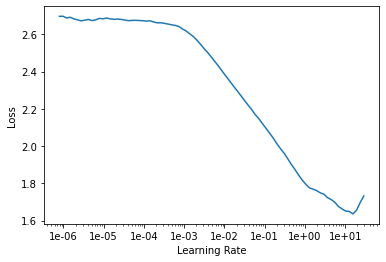

In [33]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.205117,0.311980,0.896900,00:25
1,0.133529,0.111035,0.964100,00:25
2,0.069435,0.040532,0.986900,00:25


### Refactor

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

Here, we use fast.ai function conv_layer() which already has conv, batchNorm and RELU functions inside it. So we can use that instead of what we did earlier. 

In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [38]:
#Train for longer..
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.235744,0.202638,0.940000,00:25
1,0.192418,0.573549,0.815700,00:25
2,0.160909,0.472646,0.856600,00:25
3,0.150682,0.114685,0.964400,00:25
4,0.120437,0.124162,0.960000,00:25
5,0.105185,0.066285,0.979400,00:25
6,0.085512,0.054638,0.982800,00:25
7,0.063195,0.039847,0.987700,00:25
8,0.048667,0.030407,0.990200,00:25
9,0.048840,0.028068,0.990800,00:25


Let's create a deeper network. We can do this by adding layers that do convolution at stride 1 after each layer that uses stride 2. The conv with stride 1 does not change the size of the feature map. We can add as many of them as we like. 

### Build deeper network which is Resnet-ish

In [0]:
#Adding convolution layers with stride 1
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

Adding layers does not necessarily overfit. See Residual learning paper by Kaiming He et al. Hence, we should add what is called a 'skip connection' that, instead of computing conv2(conv1(x)), will compute x+ conv2(conv1(x)). The loss landscape of the latter is less bumpier than the former, hence it does well. 

In [40]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [0]:
#New Resnet-like architecture with 2 layers of convolution with stride 1 added between layers with stride= 2
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


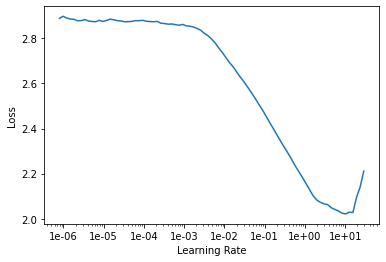

In [43]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.200824,0.120483,0.967400,00:28
1,0.133220,0.080447,0.975500,00:28
2,0.104960,0.066976,0.978400,00:28
3,0.090668,0.176897,0.946000,00:28
4,0.074837,0.252976,0.910300,00:28
5,0.059364,0.044871,0.986400,00:28
6,0.054145,0.044535,0.987100,00:28
7,0.044934,0.038701,0.987200,00:28
8,0.033434,0.020709,0.993400,00:28
9,0.028135,0.020256,0.993300,00:28


If we use the res_block() from fast.ai, we have a Merge Layer in it. This merge layer implements the skip connection that we discussed earlier. 

Let us try constructing and using a model with the fast.ai inbuilt res_block.

In [0]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


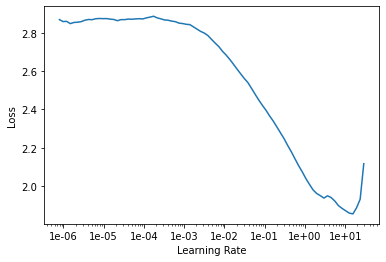

In [48]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.213748,0.120424,0.963700,00:28
1,0.133055,0.147907,0.951800,00:28
2,0.114649,0.098040,0.968300,00:28
3,0.089375,0.081985,0.975000,00:28
4,0.075393,0.117048,0.962400,00:28
5,0.061593,0.046259,0.984700,00:28
6,0.049076,0.035147,0.988100,00:28
7,0.039786,0.033014,0.988800,00:28
8,0.035100,0.025198,0.992000,00:28
9,0.026061,0.018901,0.994000,00:28


In [50]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

Note the MergeLayer that has been created that implements skip connections for the added layers that have convolution with stride 1. We may not get good results without this crucial step.

MergeLayer has a parameter called 'dense' which, if set, catenates x with conv2(conv1(x)) instead of adding and leads to a model called Dense Net instead of ResNet. 

Note conv2 and conv1 do not mean 2D and 1D conv, but rather the first and second conv layers of stride =1. 


The simple network we built is very effective on MNIST, giving almost state-of-the-art accuracy. 